In [111]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, adjusted_rand_score, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import warnings

# BioInformatica #2

## Data Spliting

In [96]:
df_X = pd.read_csv('X_gexp.csv')
df_Y = pd.read_csv('y_gexp.csv')
df_X.drop(columns=["Unnamed: 0"],inplace=True)
df_Y.drop(columns=["Unnamed: 0"],inplace=True)
df_X.head()

,FSTL1,ELMO2,CREB3L1,PNMA1,MMP2,SMARCD3,PKNOX2,RALYL,ZHX3,APBB2,BBOX1,EDN1,CLK4,CXCR4,SALL1,PTPRR,CXCL3,LMAN1,CHD8,MYO9B,MMP7,EP300,CRNKL1,RTN1,CENPQ,ZEB1,SOD2,SEMA4D,TOB2,BANK1,NR4A2,RICS,PIR,IPO9,CXCL13,KIAA1199,SORL1,CHD1,SERPINF1,C20orf27,...,FAM38A,APOL3,FLNA,IL2RB,DENND2D,BAX,CP,G6PC3,GORASP1,FKBP1A,FXYD3,NDUFS7,USH1C,PGPEP1,SIN3B,UTX,SEMA3C,GRAMD3,VAV1,PDGFC,S100A13,ARMCX2,CSF2RB,IFI44,RPS6KA3,PHF21A,DACT1,PAH,EAF2,C14orf101,ST18,PSMB9,ProSAPiP1,HCLS1,MMP9,KIAA0802,DHRS2,SGEF,PIK3IP1,CTSC
0,2.275179,1.873549,1.772059,2.144198,2.269443,1.742389,1.797055,1.677848,1.801352,1.786488,1.566269,1.904157,1.960675,2.181746,1.735910,1.655497,1.777042,1.723411,2.083804,1.836178,1.856192,1.997861,1.812495,1.845989,1.720724,1.746723,2.276501,2.078261,1.992680,1.738225,1.944261,1.871261,2.019692,2.051795,2.276623,1.956271,1.986708,1.892793,2.266765,2.034055,...,2.144101,2.098695,2.046487,1.976209,2.190804,1.928472,1.873692,2.067812,1.928639,2.135780,1.992313,2.165243,1.763547,1.777232,1.914788,1.654096,1.971076,1.945366,1.880740,2.248730,2.462361,1.929660,2.146675,2.153995,1.885494,2.121814,1.863953,1.658828,1.837541,1.856069,1.669895,2.346811,2.004333,2.213310,2.407606,2.083333,2.098461,1.680092,1.953595,2.429578
1,2.569520,2.085888,1.961846,2.315705,2.505400,2.226593,1.798769,1.671170,2.000942,2.089285,2.222636,1.895103,2.056812,2.264711,1.734209,1.671545,1.739476,1.743485,1.921805,1.847914,2.148095,2.024431,2.128014,2.116965,1.844122,1.959178,2.157540,1.916143,1.986719,1.701537,1.740413,1.969176,2.068862,2.112116,2.458793,2.124578,2.253694,2.078780,2.606915,2.102954,...,2.008151,1.993568,2.155755,2.047423,1.925512,1.929611,2.247885,2.244544,2.071911,2.199557,1.680173,2.179085,1.693050,1.692963,1.903436,1.789118,2.157402,2.312804,1.823846,2.394453,2.416946,2.365928,1.988303,2.361050,2.107726,2.089012,2.255728,1.644350,2.057093,1.829259,1.516024,2.339930,2.045828,2.285701,2.633632,1.938474,1.614437,1.760419,2.010156,2.431814
2,2.471492,2.030865,1.845808,2.072279,2.346815,1.783762,1.707150,1.599492,1.823480,1.778307,1.566747,2.008725,2.037835,2.301854,1.598172,1.910969,2.207883,1.837674,1.994657,1.765949,2.365116,1.998066,2.248519,1.753688,1.758790,1.920954,2.087087,2.019580,1.926774,1.761708,2.098592,1.960705,2.050674,2.013155,1.974532,2.203748,2.343177,2.070621,2.475894,1.910922,...,2.021809,1.919884,2.196082,1.938452,2.101692,2.017288,1.634701,2.163389,2.051038,2.137474,2.289957,2.124180,2.206332,1.829718,1.849718,1.946027,2.127433,2.050050,1.829796,2.349844,2.241409,2.113621,2.030815,2.009132,2.253979,2.018353,2.048471,1.991554,1.911226,2.099317,1.527561,2.302006,2.059862,2.130193,2.349831,1.815239,1.857933,1.675823,2.011970,2.434026
3,2.464403,2.094165,1.762169,2.374129,2.213562,2.209426,1.925440,1.936043,2.003743,2.024847,2.220178,1.649374,2.067852,2.259923,2.195633,1.650498,1.735527,1.784649,2.109289,1.890411,2.253762,2.048444,2.222407,2.263728,1.881578,2.217685,2.242865,1.856521,2.031705,1.603700,1.700070,1.980659,1.900345,2.165555,1.825354,1.943442,2.234925,2.187973,2.163588,2.105813,...,1.965878,1.720865,2.110520,1.729204,1.701963,2.025471,2.144613,2.188388,1.957287,2.215592,1.674759,2.244536,1.677141,1.705210,1.981721,1.824092,1.845967,2.163524,1.771452,2.356756,2.315789,2.259436,1.700927,1.893478,2.026957,2.181503,2.090457,1.613407,1.822579,2.185452,1.611626,2.208924,2.050555,2.213955,1.982603,2.125508,1.631955,1.881003,1.886280,2.450704
4,2.365457,2.188070,1.763206,2.340024,2.219210,2.308335,1.801007,1.756726,2.115714,2.086733,2.428909,1.960130,2.226506,2.048723,2.083803,1.717557,1.680709,1.824877,1.990583,1.949472,1.643570,2.059768,2.238034,2.276336,1.835634,2.207433,1.969050,1.896133,2.049466,1.836820,1.750826,2.250000,2.150701,2.200589,1.672528,1.993308,2.456943,2.196064,2.169288,2.074145,...,2.058229,1.798313,1.998871,1.734402,1.741155,1.961102,1.872801,2.198787,2.204742,2.076690,1.709713,2.281344,1.725556,1.789032,2.082944,1.863005,1.665881,2.455167,1.756719,2.287071,2.391386,2.364498,1.679934,2.187033,1.997132,2.15

In [97]:
df_X.shape

(302, 5000)

In [98]:
df_X.isna().sum()

FSTL1       0
ELMO2       0
CREB3L1     0
PNMA1       0
MMP2        0
           ..
KIAA0802    0
DHRS2       0
SGEF        0
PIK3IP1     0
CTSC        0
Length: 5000, dtype: int64

In [99]:
df_Y.shape

(302, 1)

## Data Pre Processing

In [100]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_X)

## Feature selection

Initialize the dictionary that will contain the df_X resultant of all feature selection methods used. We set the maximum of features to haver to be 500 (10% of the original dataset).

In [101]:
feature_reductions = {}

Minimal Variance Treshold:

* Removes low-variance features (assumes features are on the same scale).

* If features are not scaled, variance will be biased toward features with larger magnitudes.

* Needs StandardScaler before applying.

The treshold means ....., and by increasing this hyperparanter the number of features decreases.

In [102]:
variance = VarianceThreshold(threshold=1.0) 
X_filtered = variance.fit_transform(X_scaled)
selected_features_variance = df_X.columns[variance.get_support()]


if len(selected_features_variance) > 500:
    variances = np.var(X_scaled[:, variance.get_support()], axis=0)
    top_indices = np.argsort(variances)[-500:]
    selected_features_variance = selected_features_variance[top_indices]

x = df_X[selected_features_variance]
print(f"Variance Threshold selected {x.shape[1]} features (max 500)")
feature_reductions["Variance Threshold"] = x

Variance Threshold selected 500 features (max 500)


Principal Component Analysis (PCA)

* PCA is variance-based and highly sensitive to feature scales.

* Needs StandardScaler before applying.

In [103]:
pca = PCA(n_components=0.99, random_state=42)
X_pca = pca.fit_transform(X_scaled)

y = pd.DataFrame(X_pca, index=df_X.index, 
                columns=[f"PC_{i+1}" for i in range(pca.n_components_)])
print(f"PCA kept {y.shape[1]} components")
feature_reductions["PCA"] = y

PCA kept 265 components


ANOVA F-test

* Measures the relationship between each feature and the target variable (categorical).

* Based on variance ratios, not absolute values.

* Does not need StandardScaler.

In [104]:
k = min(500, df_X.shape[1]) 
anova = SelectKBest(score_func=f_classif, k=k)
X_selected = anova.fit_transform(df_X, df_Y)
selected_features_anova = df_X.columns[anova.get_support()]
z = df_X[selected_features_anova]
print(f"ANOVA selected {z.shape[1]} features")
feature_reductions["ANOVA"] = z

ANOVA selected 500 features


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Correlation with the Target Variable

* Does not use StandardScaler

In [105]:
target_correlation = pd.concat([df_X, df_Y], axis=1).corr()[df_Y.columns[0]].abs()
target_correlation = target_correlation.drop(df_Y.columns[0]).sort_values(ascending=False)
top_n = min(500, len(target_correlation))  
selected_features_correlation = target_correlation.head(top_n).index
w = df_X[selected_features_correlation]
print(f"Correlation selected {w.shape[1]} features")
feature_reductions["Correlation"] = w

Correlation selected 500 features


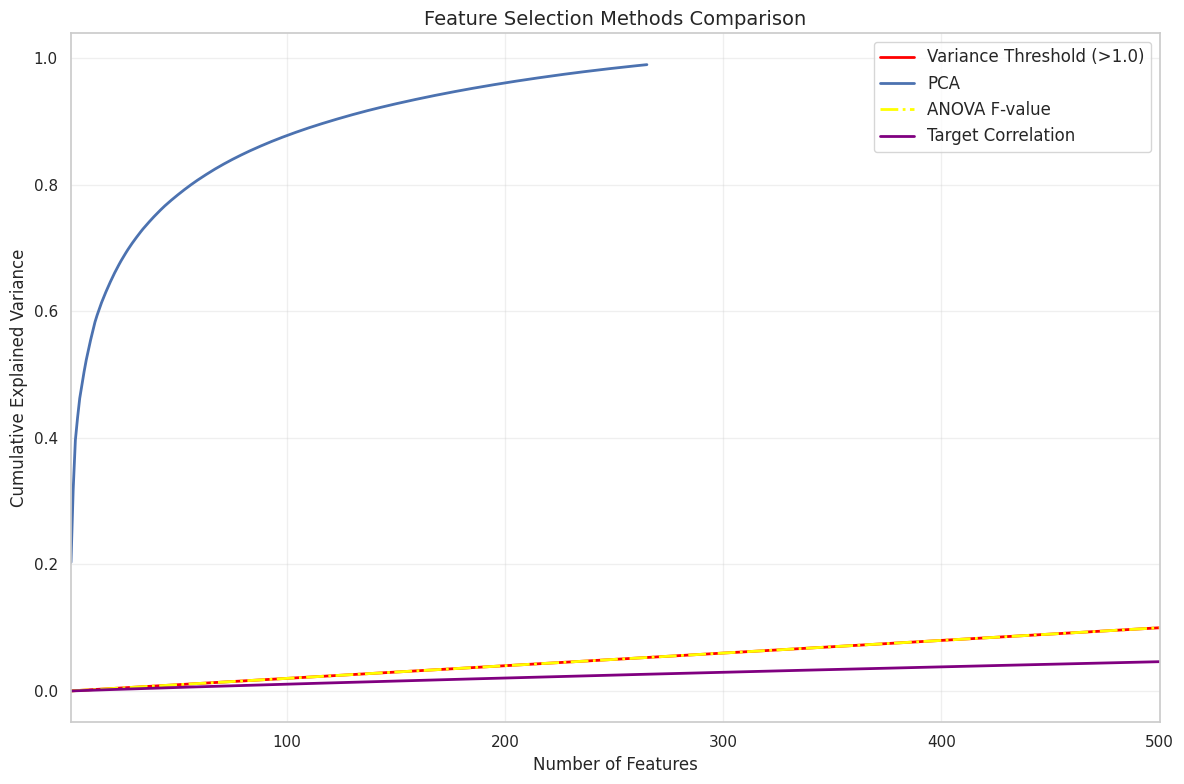

In [106]:
plt.figure(figsize=(12, 8))

# --- 1. VarianceThreshold ---
selected_variances = np.var(X_scaled[:, variance.get_support()], axis=0)
sorted_selected_variances = np.sort(selected_variances)[::-1]
cumulative_variance_selected = np.cumsum(sorted_selected_variances) / np.sum(np.var(X_scaled, axis=0))
plt.plot(range(1, len(cumulative_variance_selected)+1), 
         cumulative_variance_selected, linestyle='-',  color="red",
         label='Variance Threshold (>1.0)', linewidth=2)

# --- 2. PCA ---
pca_cumulative = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, min(501, len(pca_cumulative)+1)), 
         pca_cumulative[:500], linestyle='-',
         label='PCA', linewidth=2)

# --- 3. ANOVA ---
anova_scores = anova.scores_
sorted_indices = np.argsort(anova_scores)[::-1]
sorted_variances_anova = np.var(X_scaled, axis=0)[sorted_indices]
cumulative_variance_anova = np.cumsum(sorted_variances_anova) / np.sum(np.var(X_scaled, axis=0))
plt.plot(range(1, min(501, len(cumulative_variance_anova)+1)), 
         cumulative_variance_anova[:500], linestyle='-.', color="yellow",
         label='ANOVA F-value', linewidth=2)

# --- 4. Target Correlation ---
cumulative_variance_corr = np.cumsum(target_correlation) / np.sum(np.var(X_scaled, axis=0))
plt.plot(range(1, min(501, len(cumulative_variance_corr)+1)), 
         cumulative_variance_corr[:500], linestyle='-', color="purple",
         label='Target Correlation', linewidth=2)

# --- Final plot customization ---
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Feature Selection Methods Comparison', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(1, min(500, X_scaled.shape[1]))
plt.tight_layout()
plt.show()



Selected features by type of method

In [107]:
print(feature_reductions)

{'Variance Threshold':          NAV2      SCG2      KLK7  ...      ANK2       PGF  TMEM185B
0    2.215275  1.887834  1.730437  ...  1.661523  1.725847  1.905063
1    2.100200  2.346226  1.623967  ...  2.095947  1.974241  2.159203
2    1.901059  2.079891  1.845552  ...  1.775366  1.768483  1.973325
3    2.210773  2.493276  1.614682  ...  2.156636  1.824847  2.032254
4    2.264473  2.359501  1.625020  ...  2.337900  1.709636  1.923691
..        ...       ...       ...  ...       ...       ...       ...
297  2.281648  2.153420  1.653830  ...  2.215766  1.879985  1.900055
298  2.275639  2.263439  1.630903  ...  2.364616  1.995582  2.112871
299  2.258022  2.338533  1.637654  ...  2.343170  1.963733  2.074856
300  2.309625  2.378268  1.681708  ...  2.342341  1.780629  2.051113
301  2.089991  2.519974  1.654914  ...  2.364879  2.001711  2.076570

[302 rows x 500 columns], 'PCA':           PC_1       PC_2       PC_3  ...    PC_263    PC_264    PC_265
0   -83.787383  36.172080  -1.128126  ...  

## Model training & testing

### Supervised Learning

In [112]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100),
    "QDA": QuadraticDiscriminantAnalysis(),
    "Neural Network": MLPClassifier()
}

kf = StratifiedKFold(n_splits=5, shuffle=True)

warnings.filterwarnings("ignore")

#################################
# Evaluating LogisticRegression #
#################################

#################################
#    With Variance Threshold    #
#################################

Accuracy: 0.920
Precision: 0.932
Recall: 0.917
F1: 0.922



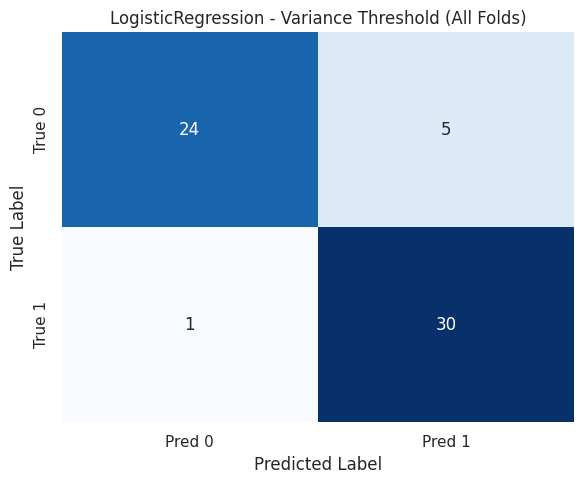

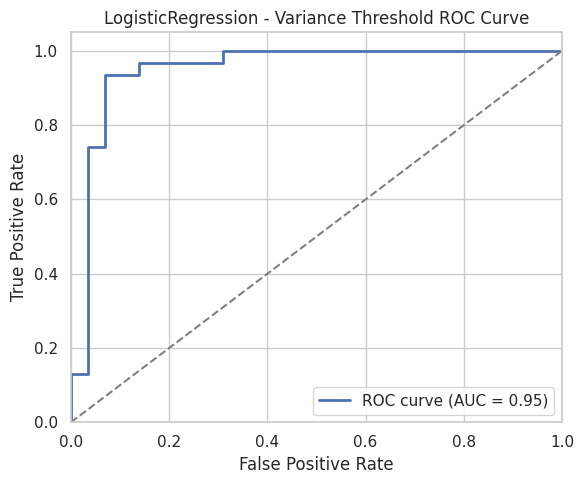


#################################
#           With PCA            #
#################################

Accuracy: 0.606
Precision: 0.621
Recall: 0.612
F1: 0.616



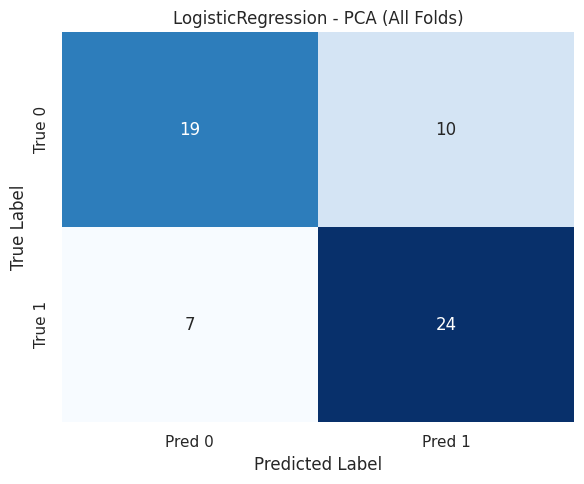

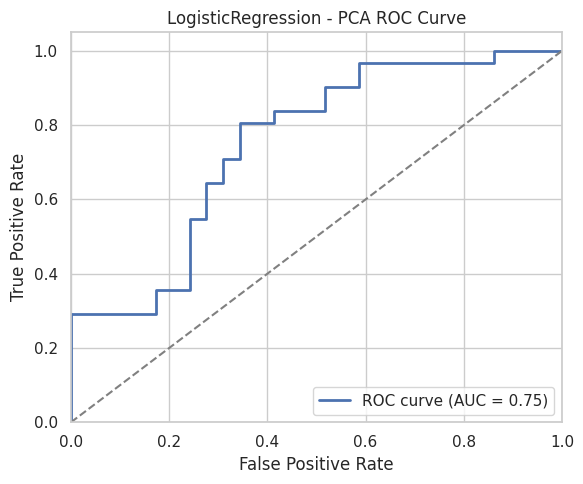


#################################
#          With ANOVA           #
#################################

Accuracy: 0.937
Precision: 0.942
Recall: 0.937
F1: 0.939



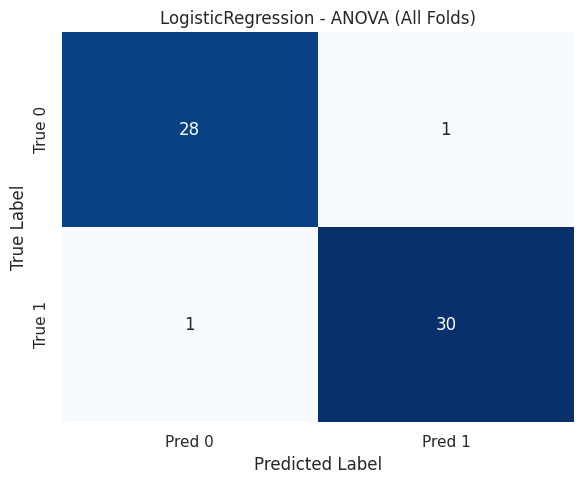

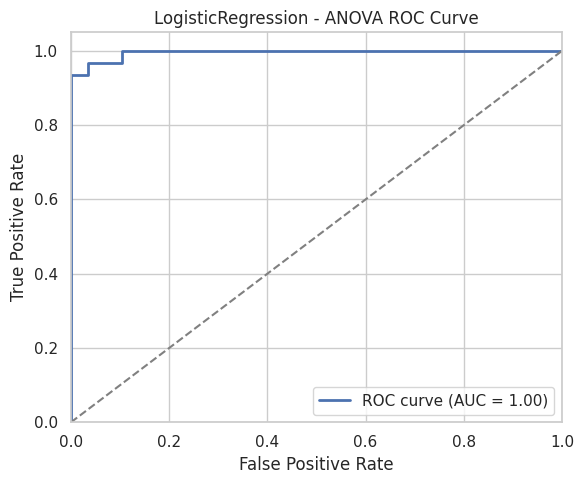


#################################
#       With Correlation        #
#################################

Accuracy: 0.917
Precision: 0.931
Recall: 0.911
F1: 0.918



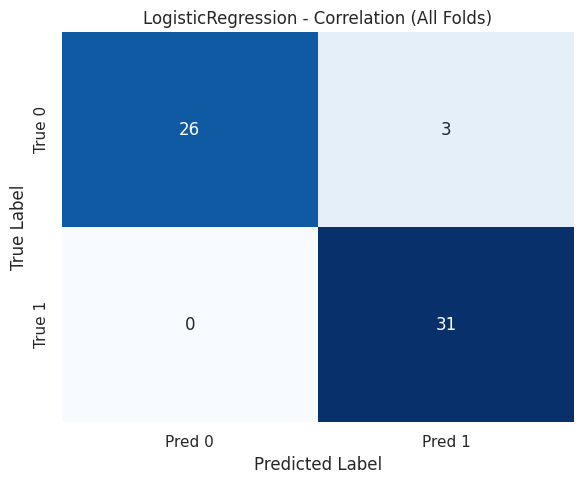

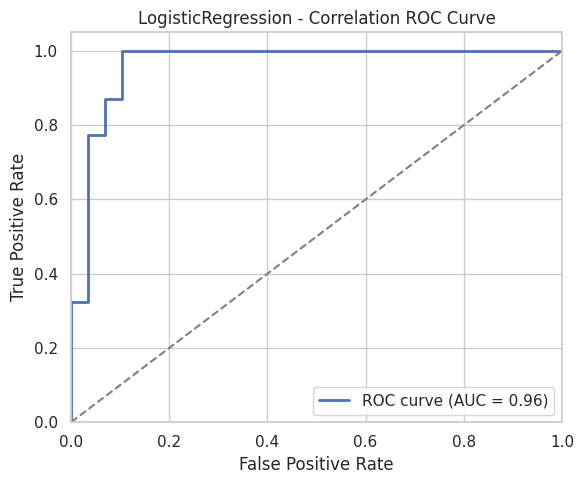


#################################
#    Evaluating RandomForest    #
#################################

#################################
#    With Variance Threshold    #
#################################

Accuracy: 0.894
Precision: 0.898
Recall: 0.898
F1: 0.898



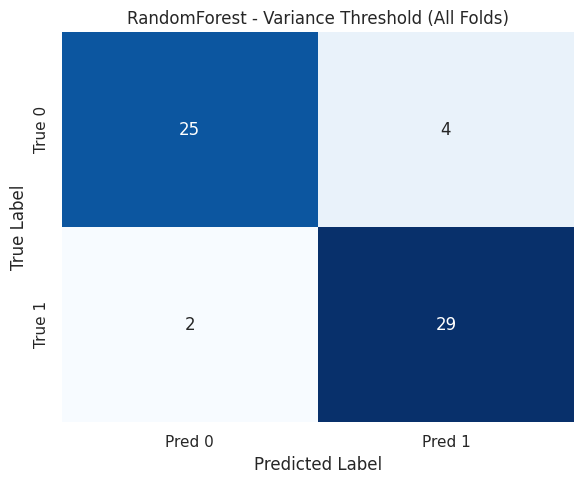

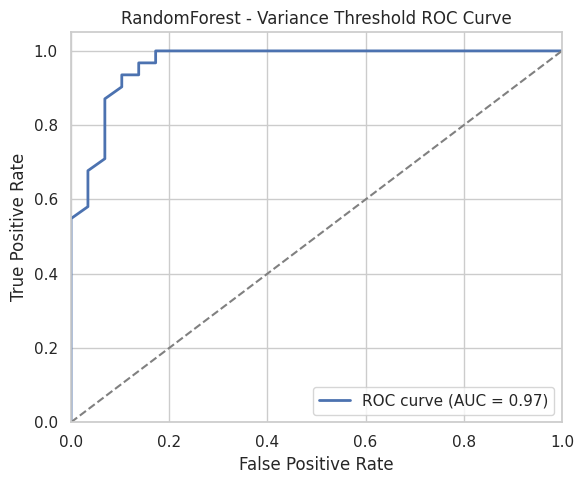


#################################
#           With PCA            #
#################################

Accuracy: 0.861
Precision: 0.857
Recall: 0.879
F1: 0.867



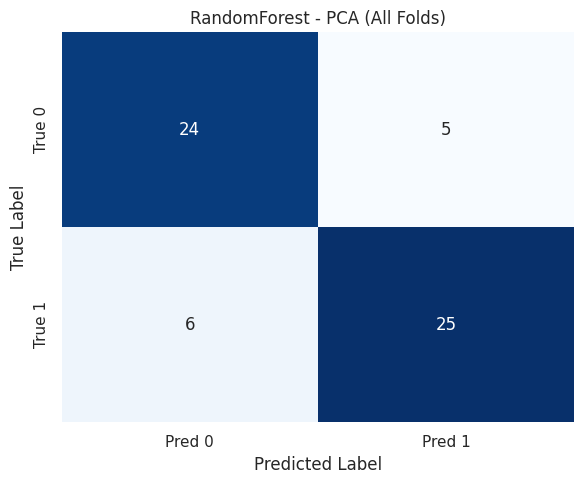

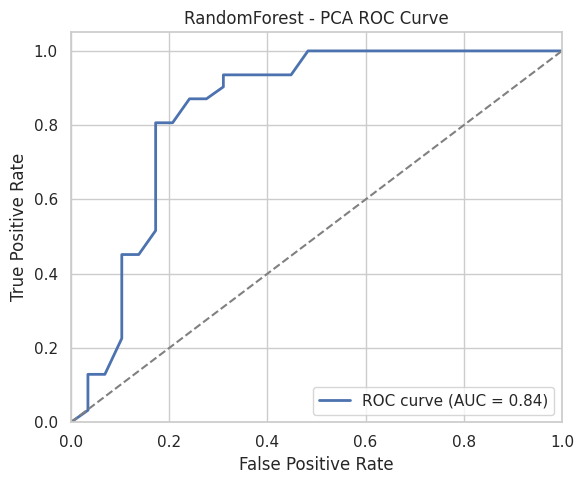


#################################
#          With ANOVA           #
#################################

Accuracy: 0.927
Precision: 0.916
Recall: 0.949
F1: 0.932



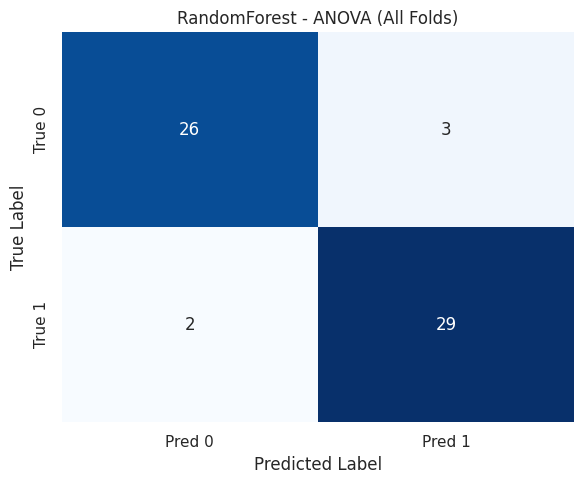

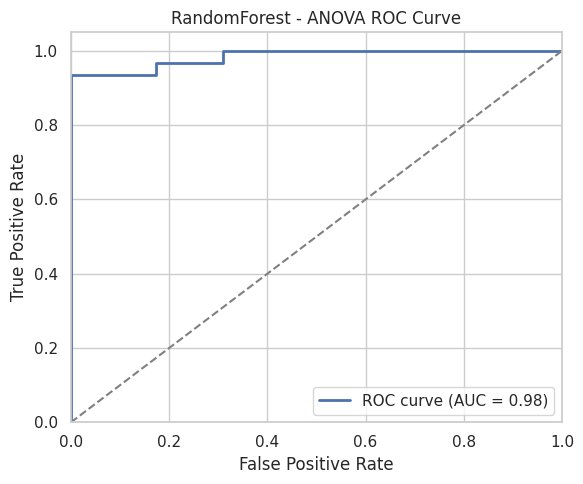


#################################
#       With Correlation        #
#################################

Accuracy: 0.927
Precision: 0.906
Recall: 0.962
F1: 0.932



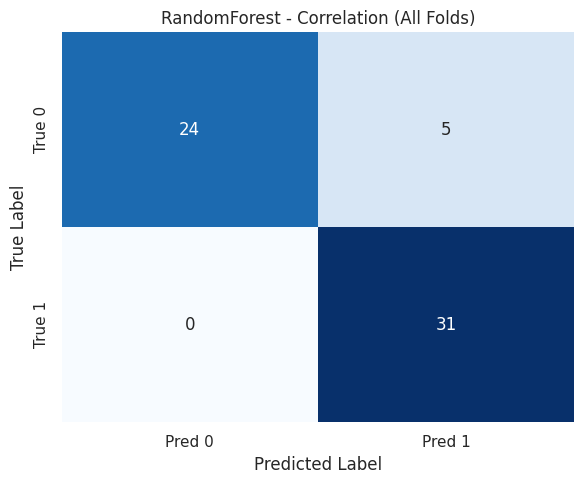

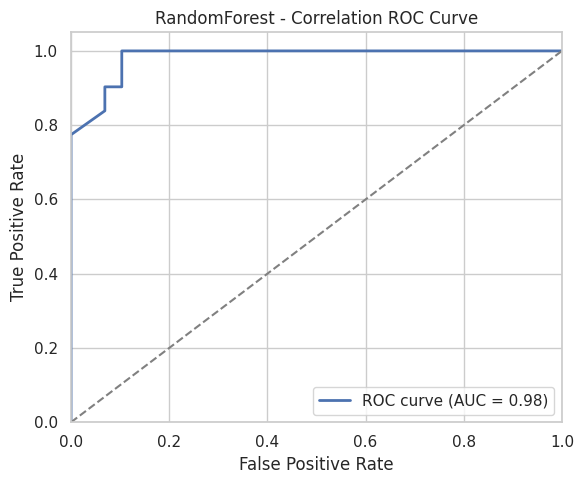


#################################
#        Evaluating QDA         #
#################################

#################################
#    With Variance Threshold    #
#################################

Accuracy: 0.480
Precision: 0.500
Recall: 0.516
F1: 0.507



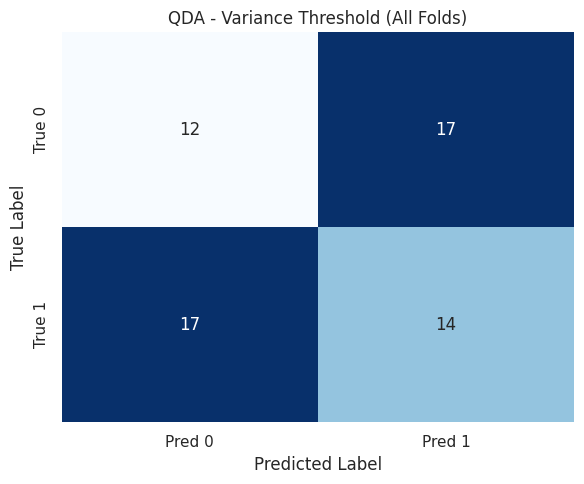

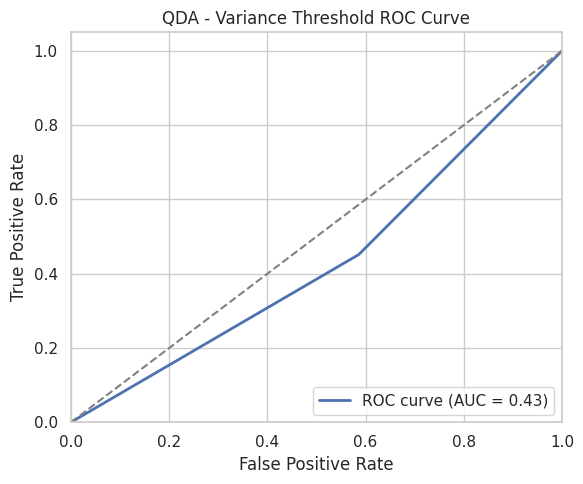


#################################
#           With PCA            #
#################################

Accuracy: 0.573
Precision: 0.585
Recall: 0.644
F1: 0.610



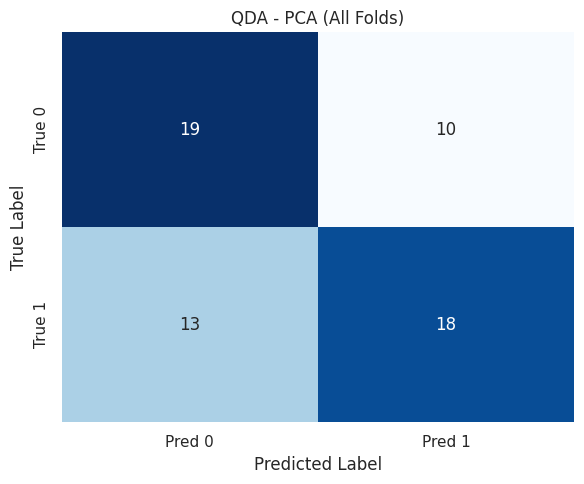

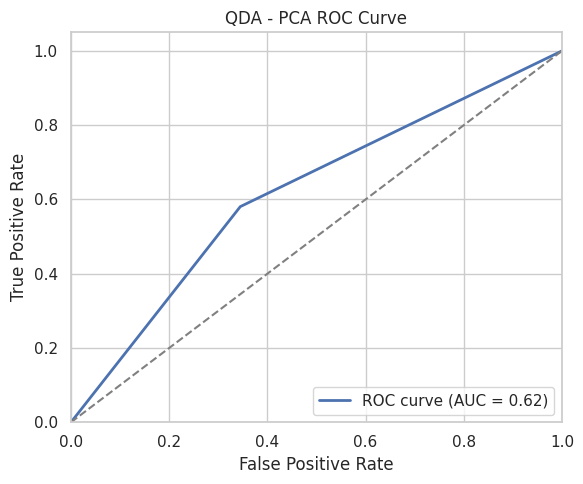


#################################
#          With ANOVA           #
#################################

Accuracy: 0.556
Precision: 0.573
Recall: 0.599
F1: 0.585



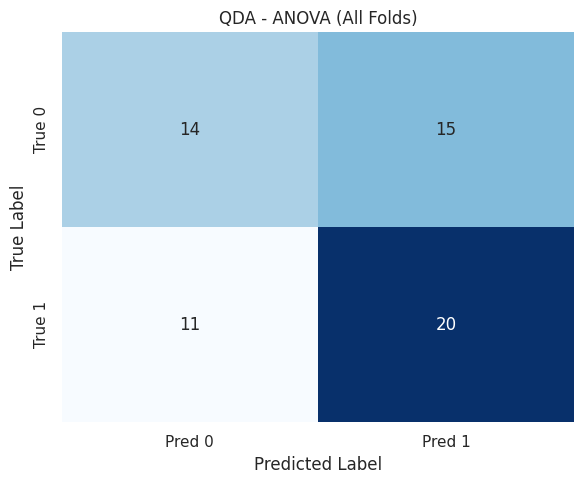

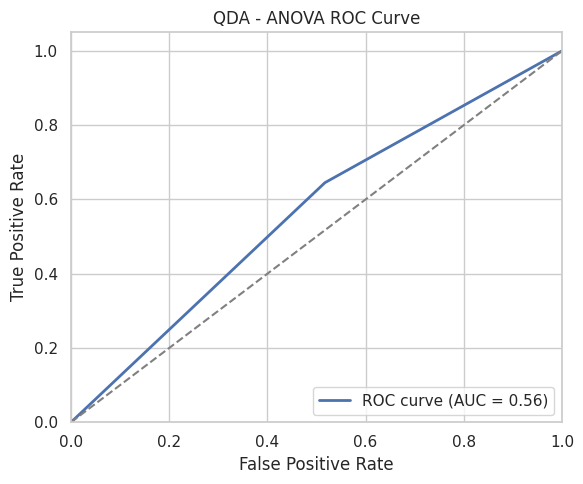


#################################
#       With Correlation        #
#################################

Accuracy: 0.553
Precision: 0.575
Recall: 0.555
F1: 0.562



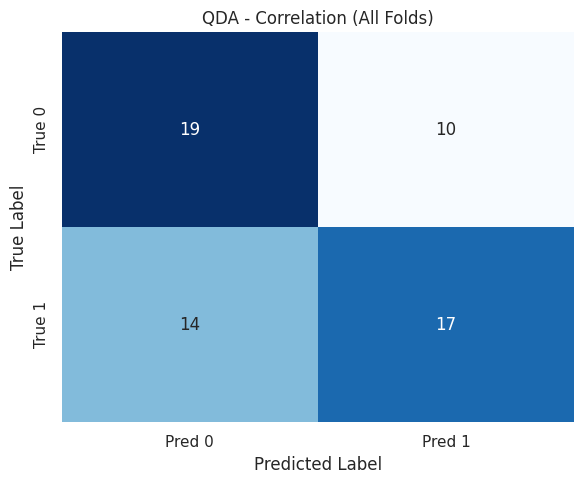

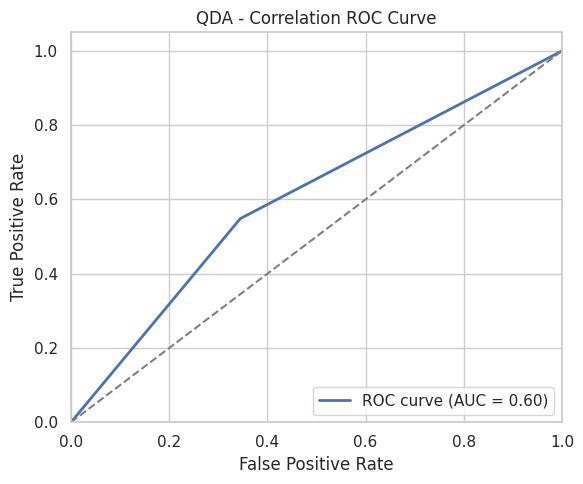


#################################
#   Evaluating Neural Network   #
#################################

#################################
#    With Variance Threshold    #
#################################

Accuracy: 0.920
Precision: 0.929
Recall: 0.917
F1: 0.923



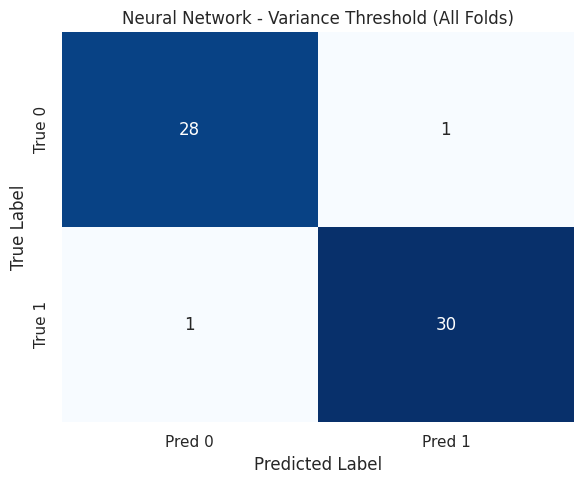

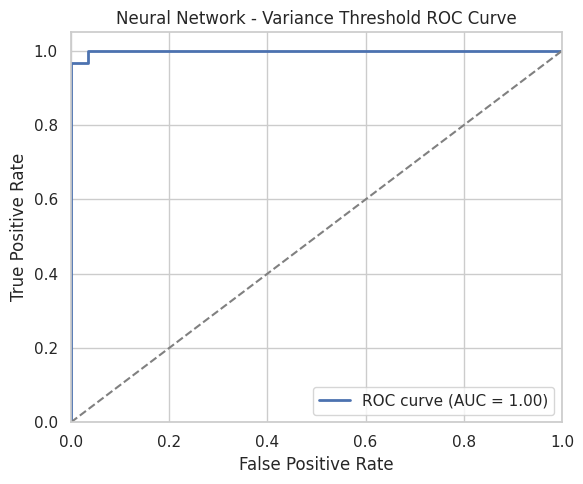


#################################
#           With PCA            #
#################################

Accuracy: 0.381
Precision: 0.406
Recall: 0.394
F1: 0.399



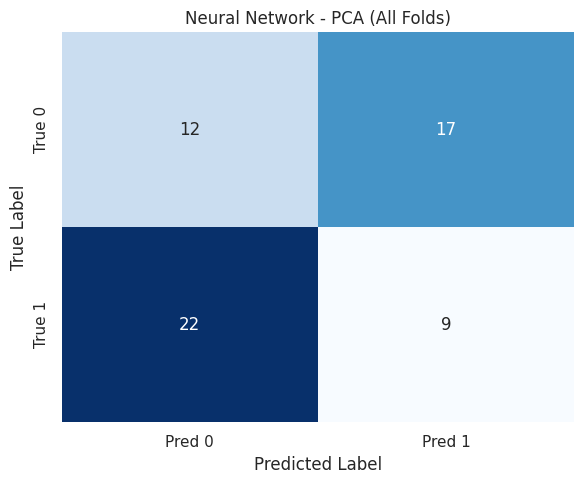

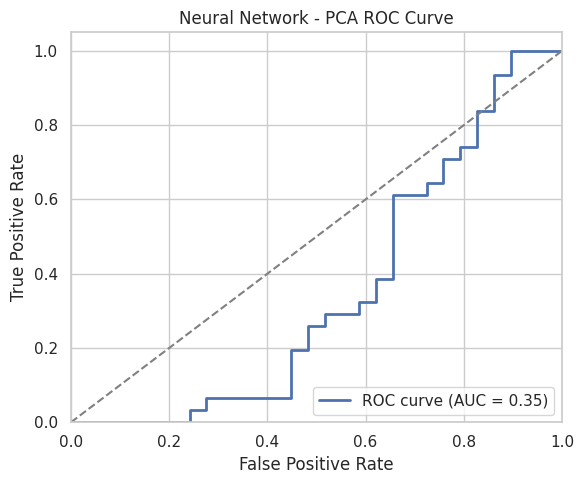


#################################
#          With ANOVA           #
#################################

Accuracy: 0.940
Precision: 0.937
Recall: 0.949
F1: 0.943



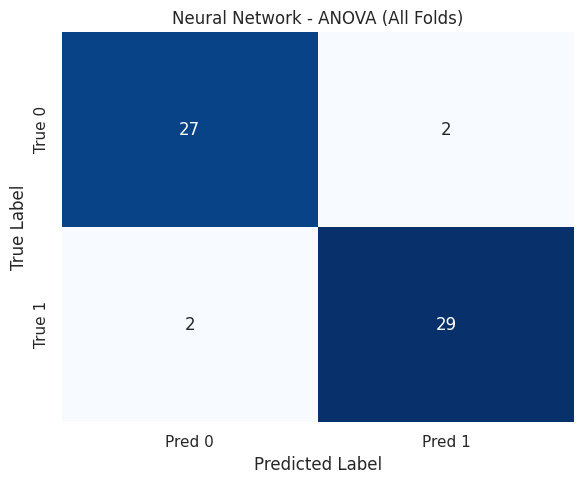

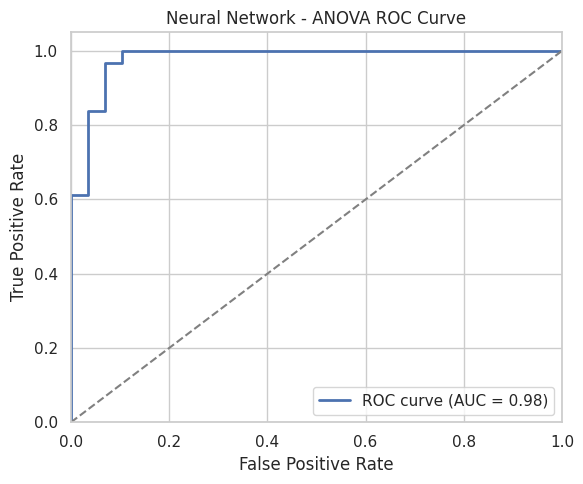


#################################
#       With Correlation        #
#################################

Accuracy: 0.947
Precision: 0.946
Recall: 0.955
F1: 0.949



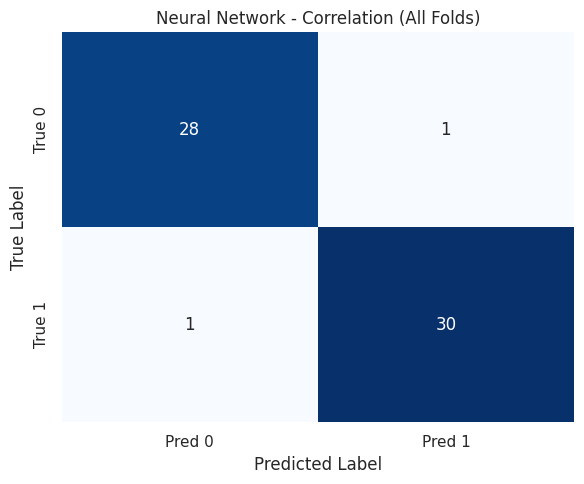

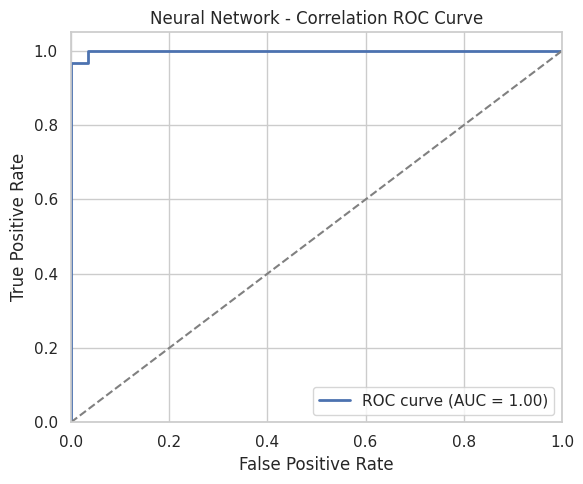

In [113]:
all_results = {}

for name, model in models.items():
    model_results = {}
    print("#################################")
    spaces_left = len("#################################")-len(f"Evaluating {name}")-2
    print("#"+ " "*(int(np.floor(spaces_left/2)))+ f"Evaluating {name}"+ " "*(int(np.ceil(spaces_left/2)))+ "#")
    print("#################################\n")

    for method_name, df in feature_reductions.items():
        print("#################################")
        spaces_left = len("#################################")-len(f"With {method_name}")-2
        print("#"+ " "*(int(np.floor(spaces_left/2)))+ f"With {method_name}"+ " "*(int(np.ceil(spaces_left/2)))+ "#")
        print("#################################\n")

        metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}

        all_y_true = []
        all_y_pred = []
        all_y_prob = []

        df = df.values
        for train_idx, test_idx in kf.split(df, df_Y):

            X_train, X_test = df[train_idx], df[test_idx]
            y_train, y_test = df_Y.iloc[train_idx], df_Y.iloc[test_idx]

            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', model)
            ])
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            y_proba = pipeline.predict_proba(X_test)[:, 1]

            metrics["accuracy"].append(accuracy_score(y_test, y_pred))
            metrics["precision"].append(precision_score(y_test, y_pred))
            metrics["recall"].append(recall_score(y_test, y_pred))
            metrics["f1"].append(f1_score(y_test, y_pred))

            all_y_prob = np.array(y_proba).flatten()
            all_y_true = np.array(y_test).flatten()
            all_y_pred = np.array(y_pred).flatten()

        model_results[method_name] = {"accuracy": np.mean(metrics["accuracy"]),
                                      "precision": np.mean(metrics["precision"]),
                                      "recall": np.mean(metrics["recall"]),
                                      "f1": np.mean(metrics["f1"])}

        print(f"Accuracy: {model_results[method_name]['accuracy']:.3f}")
        print(f"Precision: {model_results[method_name]['precision']:.3f}")
        print(f"Recall: {model_results[method_name]['recall']:.3f}")
        print(f"F1: {model_results[method_name]['f1']:.3f}\n")

        cm = confusion_matrix(all_y_true, all_y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"{name} - {method_name} (All Folds)")
        plt.tight_layout()
        plt.show()


        fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 5))
        sns.set(style='whitegrid')
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', linewidth=2)
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray') 
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"{name} - {method_name} ROC Curve")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

        print()

    all_results[name] = model_results



Print the table with all acuracies from the different methods.

In [ ]:
results_table = pd.DataFrame({
    model_name: {
        method: metrics["accuracy"] 
        for method, metrics in model_metrics.items()
    }
    for model_name, model_metrics in all_results.items()
}).T 


results_table_styled = results_table.style \
    .format("{:.3f}") \
    .set_caption("Model Accuracy by Feature Selection Method") \
    .set_properties(**{'text-align': 'center'}) \
    .background_gradient(cmap='Blues', subset=pd.IndexSlice[:, :])


display(results_table_styled)

,Variance Threshold,PCA,ANOVA,Correlation
LogisticRegression,0.920,0.606,0.937,0.917
RandomForest,0.894,0.861,0.927,0.927
QDA,0.480,0.573,0.556,0.553
Neural Network,0.920,0.381,0.940,0.947


### Unsupervised Learning